# Meteo 515 – Assignment 4 – EOF analysis¶

In [1]:
from __future__ import division, print_function
#from collections import OrderedDict
from glob import glob
#from itertools import chain

import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import scipy.linalg as sla
#import scipy.optimize as so
#import scipy.stats as ss
#import sklearn as skl
import statsmodels.api as sm
import xarray as xr

In [2]:
plt.style.use('seaborn-darkgrid') # 'bmh', ggplot', 'seaborn-darkgrid'
%matplotlib notebook

## Load the data

### First, create container for the results that also does the EOF calculation
$\renewcommand{\vec}[1]{\mathbf{#1}}$
We can get the eigenvectors (EOFs), corresponding eigenvalues, and the principal component vectors (PCs) efficiently by first determining the singular value decomposition (SVD) of the data matrix $\vec{X}$. 
$$
\vec{X} = \vec{U} \vec{S} \vec{V}^T
$$

* $\vec{U}$: columns are called the right singular vectors
* $\vec{S}$: diagonal matrix of the singular values of $\vec{X}$
* $\vec{V}^T$: columns are called the left singular vectors; rows are the EOFs / principal directions

The EOFs / principal directions are given from this decomposition as $\vec{V}$ (equivalently, eigenvectors of the covariance matrix), the eigenvalues of the covariance matrix as $\lambda_i = s_i^2 / (n-1)$, and the principal components (individual elements are called "scores") by $\vec{U} \vec{S} = \vec{X} \vec{V}$. These definitions assume rows are samples and and columns are variables. To accomodate this we transpose our $\vec{X}$, though we could instead keep the data matrix as is and simply switch the two definitions, e.g., EOFs = $\vec{X} \vec{V}$.

[reference](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca/134283#134283)

In [9]:
class o(object):
    """hw4 results obj
    for one dataset, the things we want to save"""
    def __init__(self, fname, ID, dset,
                 ):
        self.fname = fname
        self.ID = ID
        self.dset = dset
        
        self.calc_eofs()
        
        
    def calc_eofs(self):
        """calc EOFs
        note that SVD method may fail. should have a fallback...
        """
        #> prepare input data
        X = self.dset['data'].values.T
        X -= X.mean(axis=0)  # X must be centered for the PCA from SVD formulas to apply
        #print(X.mean(axis=0))
        #print(X.shape)
        
        #> compute SVD
        U, s, V_T = sla.svd(X, full_matrices=False)  # don't need square U
        S = sla.diagsvd(s, *X.shape)  # m x n diagonal matrix, i.e. not necess square, where X is m x n
        #print(U.shape, S.shape, V_T.shape)
        n = s.size
        V = V_T.T
        
        #> adjust signs so that largest loadings are positive
        # taken from skl: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/extmath.py
        max_abs_cols = np.argmax(np.abs(U), axis=0)
        signs = np.sign(U[max_abs_cols, range(U.shape[1])])
        #print(signs)
        U *= signs
        V *= signs#[:,np.newaxis]
        
        #> compute PCs and EOFs
        self.eofs    = V #U @ S #V
        self.evals   = s**2 / (n-1)
        self.pcs     = X @ V # X @ V, U @ S
        self.pcs_std = np.sqrt(n-1) * U  # standardized PCs
        self.ldngs   = V @ np.diag(s) / np.sqrt(n-1)  # loadings; V is square so must use np.diag(s) to mult
        
        #> explained variance by each PC
        self.evals_sum = self.evals.sum()
        self.rsqd_expl = self.evals / self.evals_sum
        imax = np.where(np.cumsum(self.rsqd_expl) >= 0.90)[0][0]
        self.n_retain = imax + 1 if imax <= 6 else 8

### Now apply to the datasets

In [4]:
files = sorted(glob('./data/sine_wave_data*.nc'))
lbls = ['dset {:d}'.format(x) for x in range(1, len(files)+1)]

os = []
for fname, l in zip(files, lbls):
    os.append(o(fname, l, xr.open_dataset(fname)))

## a) Plot standardized principal components (PCs)

Dividing a principal component vector by the square-root of corresponding eigenvalue of the covariance matrix normalizes it, i.e., giving a variance of 1. This is because the eigenvalue is equal to the variance of its corresponding PC. 

But note that we also still have to subtract the mean to center it around 0. Dataset 1 for example, has a mean of 0 only if the dataset is the right length. 

In [5]:
# Some settings used in other plots
colors = plt.cm.Dark2(np.linspace(0, 1, 8))[:8]
hspace = 0.3
figsize = (8, 7)
leg_fs = 8

<IPython.core.display.Javascript object>


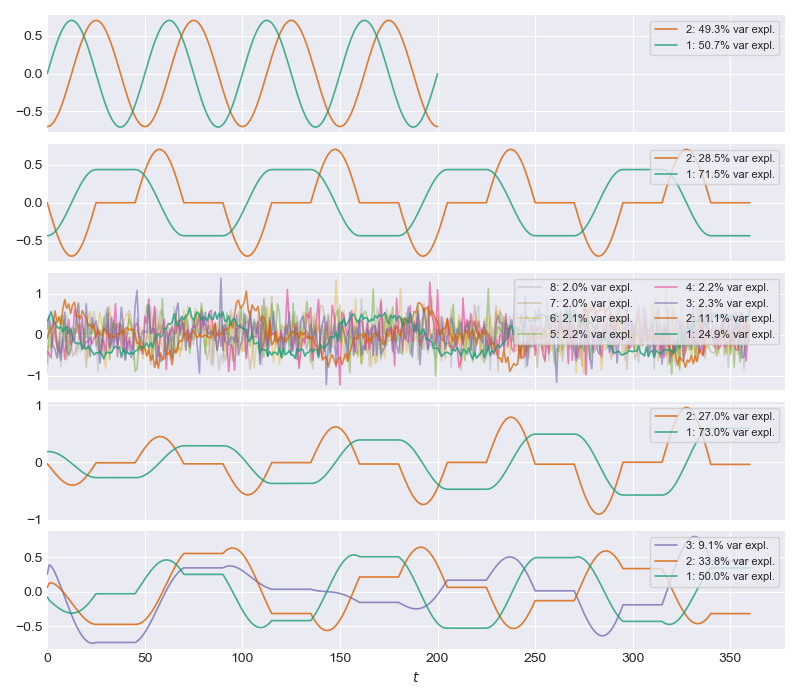

In [6]:
f1, aa = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='PCs')

for i, o in enumerate(os):
    
    a = aa.flat[i]
    
    evals = o.evals[:o.n_retain]
    pcs   = o.pcs[:,:o.n_retain]
    pcts  = o.rsqd_expl[:o.n_retain] * 100
    
    for j in range(pcs.shape[1]-1, 0-1, -1):  # plot PCs in reverse order
        s = '{:d}: {:.1f}% var expl.'.format(j+1, pcts[j])
        pc_j = pcs[:,j]
        alpha = 0.2 + 0.6*(o.n_retain-1-j)/(o.n_retain-1) if i == 2 else 0.8
        #print(pc_j.mean())
        a.plot((pc_j - pc_j.mean())/np.sqrt(evals[j]), 
               c=colors[j], lw=1.2, alpha=alpha, label=s)
    
    ncol = 1 if o.n_retain <= 4 else 2
    a.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)

aa[0].set_xlim(left=0)
aa[-1].set_xlabel('$t$')

f1.tight_layout(h_pad=hspace);

**Discussion:**

In order, these are descriptions of the data that the Prof created for this assignment:

1. Propagating sine wave
2. Propagating sine wave that stalls when it is either a positive or negative sine curve
3. Propagating sine wave with stalling and additional random noise
4. Propagating sine wave with stalling and increasing amplitude with time
5. Propagating sine wave with stalling and increasing frequency with time

We can see easily all of these features in the above time series of the PCs. For example, in panels 2–5 we can clearly see the stalling pattern in the first 2 or 3 PCs. In panel 3, although it is noisy, we can still see the stalled sine wave pattern in the first 2 PCs. In 1, 2, and 4, we can see that the two PCs 1 and 2 combine to explain 100% of the variance in the original data. This means that we could use these two PCs to reconstruct the original data perfectly--a very effective data compression. In the random noise case (panel 3), compression would lead to significant reconstruction error. Case 5 does not meet the stationarity assumption of PCA, since the component frequencies in the data (i.e., the frequency spectrum) are changing over time. However, 3 PCs explain most of the variability (93%) in the data.  

## b) Regress the standardized PCs onto the original data

Note that since the PCs are uncorrelated to each other, running SLR individually for each PC gives the same results (or at least seemingly identical). The following code does that:
```python
#> run SLR for the ts at each x position
#  for each PC individually
fits = []
for j in range(Y.shape[0]):
    y = Y[j,:]
    fits_j = []
    for k in range(X.shape[1]):
        x = X[:,k]
#        fit = sm.OLS(y, sm.add_constant(x)).fit()
        fit = sm.OLS(y, x).fit()
        fits_j.append(fit)
    fits.append(fits_j)

resids = np.array([fit.resid  for fitsj in fits for fit in fitsj])
#slopes = np.array([fit.params[1] for fitsj in fits for fit in fitsj]).reshape((Y.shape[0], k+1))   
slopes = np.array([fit.params[0] for fitsj in fits for fit in fitsj]).reshape((Y.shape[0], k+1)) 
```

Note that the PCs should have a mean of 0 already (and effectively do, considering the computer precision), but the combination of subtracting the mean and including a constant in the linear model seems to (very) slightly improve results when comparing to the plot of scaled EOFs in (c).

<IPython.core.display.Javascript object>


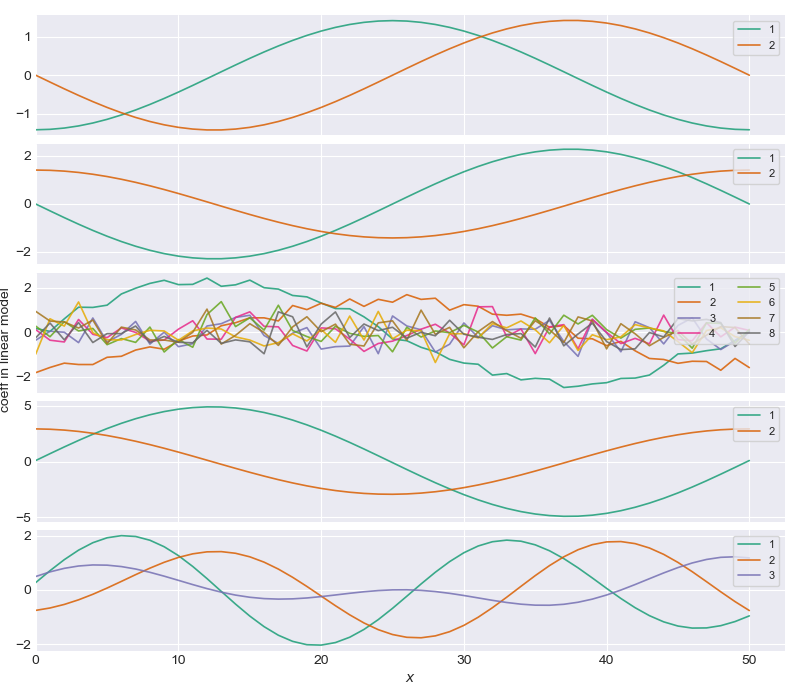

<IPython.core.display.Javascript object>


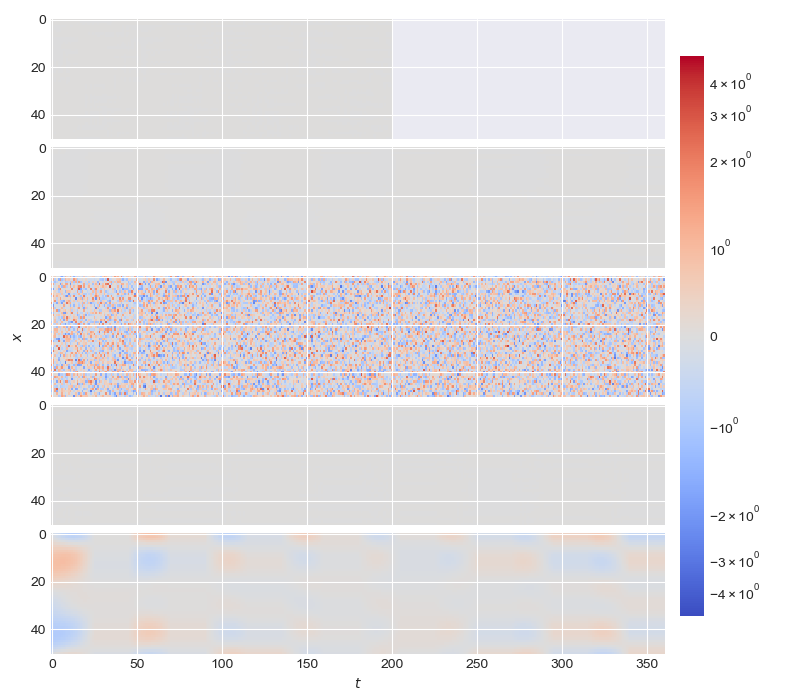

In [7]:
f2, aa = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='MLR_PCs_slopes')
f2b, aab = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='MLR_PCs_resid')

fits_coeffs_all = []
for i, o in enumerate(os):
    
    a = aab.flat[i]
    a2 = aa.flat[i]

    pcs = o.pcs[:,:o.n_retain]
    Y = o.dset.data.values
    #X = o.pcs_std[:,:o.n_retain]
    #X = pcs / np.sqrt(o.evals[:o.n_retain])
    #X = (pcs - pcs.mean(axis=0)) / np.sqrt(o.evals[:o.n_retain])
    #X = np.hstack((np.ones((Y.shape[1], 1)), pcs / np.sqrt(o.evals[:o.n_retain])))
    X = np.hstack((np.ones((Y.shape[1], 1)), (pcs - pcs.mean(axis=0)) / np.sqrt(o.evals[:o.n_retain])))
    
    #> run MLR for the ts at each x position
    fits = []
    for j in range(Y.shape[0]):
        y = Y[j,:]
        fit = sm.OLS(y, X).fit()  # model fit (coefficients etc.) for the least-squares soln
        fits.append(fit)
    resids = np.array([fit.resid for fit in fits])
    #slopes = np.array([fit.params for fit in fits])
    slopes = np.array([fit.params[1:] for fit in fits])  # if including a const in the linear model
    fits_coeffs_all.append(slopes)
    
    #> plot slopes
    for j in range(slopes.shape[1]):
        s = '{:d}'.format(j+1)
        a2.plot(slopes[:,j], 
                c=colors[j], lw=1.2, alpha=0.85, label=s)
        
    ncol = 1 if o.n_retain <= 4 else 2
    a2.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)        
            
    #> plot residuals as x vs t map
    im = a.imshow(resids, aspect='auto',
                  norm=mplcolors.SymLogNorm(linthresh=2, linscale=1.0, vmin=-5.0, vmax=5.0),
                  cmap='coolwarm')

#f2b.colorbar(im, orientation="vertical", pad=0.2)
f2b.tight_layout(rect=[0.02, 0.02, 0.85, 1.0], h_pad=hspace)  # call before adding new ax to avoid warning
cbaxes = f2b.add_axes([0.85, 0.12, 0.03, 0.8]) 
cb = f2b.colorbar(im, cax=cbaxes) 

aa[0].set_xlim(left=0)
aa[-1].set_xlabel('$x$')
f2.text(0., 0.5, 'coeff in linear model', 
        rotation='vertical', va='center')

aab[-1].set_xlabel('$t$')
aab[2].set_ylabel('$x$')

f2.tight_layout(h_pad=hspace);

**Discussion:**

We can imagine, for example, how the two waves in panel 1 (which could be a sine and cosine of the same wave) can be combined with the PCs in (a) to form the propagating sine wave signal in the data. 

In panels 1, 2, and 4, where the frequency of the signal in the original data does not change with time, the linear models formed using the selected PCs as predictors fit perfectly, as we can see in the above plot of the residuals. This makes sense, since we saw in (a) that in those 3 cases, 2 PCs combine to explain 100% of the total variability in the data. 


## c) Plot the EOFs scaled by the square-root of their eigenvalue

This is a plot of the loading vectors. The EOFs themselves are unit vectors. This scaling incorporates the (square-root-of) the variance explained by the corresponding PC. 

<IPython.core.display.Javascript object>


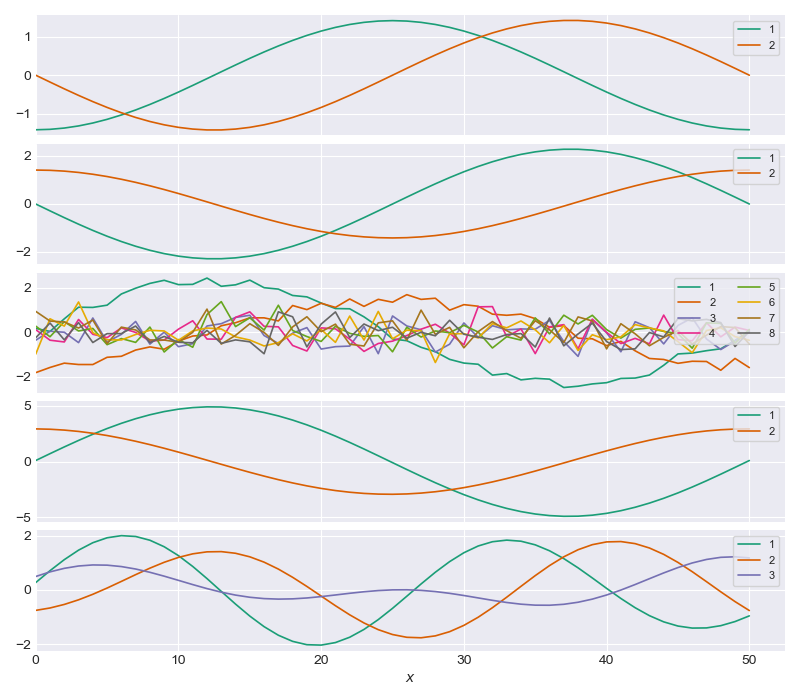

<IPython.core.display.Javascript object>


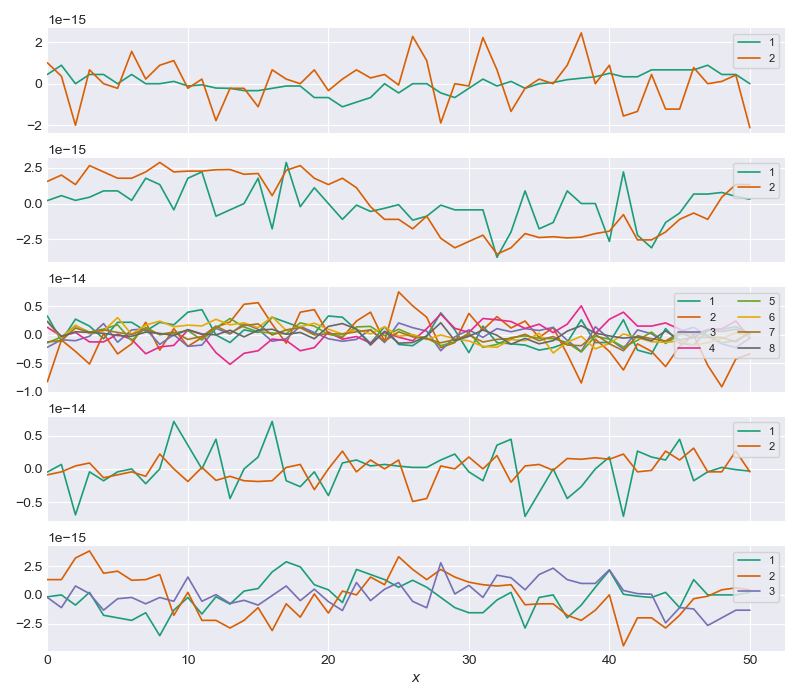

In [14]:
f3, aa = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='scaled_EOFs')

for i, o in enumerate(os):
    
    a = aa.flat[i]
    
    eofs = o.eofs[:,:o.n_retain]
    evals = o.evals[:o.n_retain]
    for j in range(eofs.shape[1]):
        s = '{:d}'.format(j+1)
        assert( np.isclose(sla.norm(eofs[:,j]), 1.0) )  # unit vectors!!
        a.plot(eofs[:,j]*np.sqrt(evals[j]), c=colors[j], lw=1.2, label=s)

    ncol = 1 if o.n_retain <= 4 else 2
    a.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)        

aa[0].set_xlim(left=0)
aa[-1].set_xlabel('$x$')

f3.tight_layout(h_pad=hspace)


f3b, aab = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='scaled_EOFs_minus_MLR_PCs')

for i, o in enumerate(os):
    
    a = aab.flat[i]
    
    eofs = o.eofs[:,:o.n_retain]
    evals = o.evals[:o.n_retain]
    for j in range(eofs.shape[1]):
        s = '{:d}'.format(j+1)
        a.plot(eofs[:,j]*np.sqrt(evals[j]) - fits_coeffs_all[i][:,j], c=colors[j], lw=1.2, label=s)

    ncol = 1 if o.n_retain <= 4 else 2
    a.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)        

aab[0].set_xlim(left=0)
aab[-1].set_xlabel('$x$')

f3b.tight_layout(h_pad=hspace);

**Discussion:**

At first glance the plot of scaled EOFs is identical to the plot of linear model coefficients from the fit of the data using the standardized PCs as predictors in (b). In fact, if we look at the 2nd plot, where we subtracting the (b) plot from the (c) plot, we see that the differences are approaching machine precision. I found that this computed residual is sensitive to the details of the PCA computation, e.g., whether $\vec{U} \vec{S}$ or $\vec{X} \vec{V}$ is used to compute the PCs. 

**Problems with PCA**